In [32]:
import numpy as np
from obp.dataset import logistic_reward_function
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds, SyntheticBanditDataset
from obp.ope import InverseProbabilityWeighting as IPS
from obp.ope import SelfNormalizedInverseProbabilityWeighting as SNIPS
from obp.ope import ImportanceWeightEstimator
from tqdm import tqdm 
from sklearn.neural_network import MLPClassifier

from obp.ope import OffPolicyEvaluation
from obp.ope import BalancedInverseProbabilityWeighting as BIPW
from obp.ope import ImportanceWeightEstimator
from obp.ope import SelfNormalizedMarginalizedInverseProbabilityWeighting as SMIPS
from obp.utils import sample_action_fast

from src.custom_estimators import NaiveMethod as NM
from src.custom_estimators import RECAP

import pandas as pd
from sklearn.preprocessing import StandardScaler
from policy import gen_eps_greedy
import matplotlib.pyplot as plt

from src.utils import read_yaml

In [33]:
random_state = 5
cfg = read_yaml('src/phase1/config.yaml')

# dataset = SyntheticBanditDatasetWithActionEmbeds(
#     n_actions=cfg['n_actions'],
#     dim_context=cfg['dim_context'],
#     beta=cfg['beta'],
#     reward_type="binary",
#     n_cat_per_dim=cfg['n_cat_per_dim'],
#     latent_param_mat_dim=cfg['latent_param_mat_dim'],
#     n_cat_dim=cfg['n_cat_dim'],
#     n_unobserved_cat_dim=cfg['n_unobserved_cat_dim'],
#     n_deficient_actions=int(cfg['n_actions'] * cfg['n_def_actions']),
#     reward_function=logistic_reward_function,
#     reward_std=cfg['reward_std'],
#     random_state=random_state,
# )

np.random.seed(random_state)
action_context = np.random.normal(size=(cfg['n_actions'], cfg['latent_param_mat_dim']))

dataset = SyntheticBanditDataset(
    n_actions=cfg['n_actions'],
    dim_context=cfg['dim_context'],
    action_context=action_context,
    beta=cfg['beta'],
    reward_type="binary",
    n_deficient_actions=int(cfg['n_actions'] * cfg['n_def_actions']),
    reward_function=logistic_reward_function,
    reward_std=cfg['reward_std'],
    random_state=random_state,
)


val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=cfg['n_val_data'],
        )

action_dist_val = gen_eps_greedy(
    expected_reward=val_bandit_data["expected_reward"],
    is_optimal=cfg['is_optimal'],
    eps=cfg['eps'],
)

pol_val = dataset.calc_ground_truth_policy_value(
    expected_reward=val_bandit_data["expected_reward"],
    action_dist=action_dist_val,
)

scaler = StandardScaler()
action_context_t = scaler.fit_transform(val_bandit_data["action_context"])

model = MLPClassifier(hidden_layer_sizes=(32,32))
model = MLPClassifier(hidden_layer_sizes=(32,32,32), activation='relu', max_iter=400)
iw_estimator = ImportanceWeightEstimator(base_model=model,
                                        n_actions=val_bandit_data["n_actions"], 
                                        action_context=action_context_t)



position = np.zeros_like(val_bandit_data["action"])

sampled_action = sample_action_fast(action_dist_val[:,:,0], 1234)

for pos_ in np.arange(iw_estimator.len_list):
    idx = position == pos_
    action_dist_at_pos = action_dist_val[idx][:, :, pos_]
    X, y = iw_estimator._pre_process_for_clf_model(
        context=val_bandit_data["context"][idx],
        action=val_bandit_data["action"][idx],
        action_dist_at_pos=action_dist_at_pos,
        sampled_action_at_position=sampled_action[idx],
    )

X1 = X[:int(len(X)/2)]
X2 = X[int(len(X)/2):]

np.save('data/x_log.npy', X1)
np.save('data/x_tar.npy', X2)

In [36]:
from src.libs.dataclass import TwoTowerDataset
from src.libs.utils import prepare_cls_data
from src.libs.classification import Classifier
from src.models.mlp import TwoTowerClassifier, MLPClassifier

context, action_emb, target = prepare_cls_data(val_bandit_data['context'],
                                               val_bandit_data['action_context'],
                                               val_bandit_data['action'],
                                               action_dist_val)


model = MLPClassifier(cfg['dim_context'], cfg['latent_param_mat_dim'], 32)

clstrainer = Classifier(val_bandit_data, action_dist_val, model, 10, verbose=True)

clstrainer.train()

probs = clstrainer.predict()
imp_weights = probs / (1-probs)
imp_weights = imp_weights / imp_weights.mean()
# imp_weights = np.minimum(imp_weights, 10)


validation score: 0.8741666666666666
validation score: 0.8855555555555555
validation score: 0.89
validation score: 0.8936111111111111
validation score: 0.8966666666666666
validation score: 0.8980555555555556
validation score: 0.8991666666666667
validation score: 0.8963888888888889
validation score: 0.8991666666666667
validation score: 0.8983333333333333


In [37]:
max(probs)

0.99999845

In [35]:
result = []
val_bandit_data["action_embed"] = val_bandit_data['action_context'][val_bandit_data['action']]

# imp_weights_x = iw_estimator.fit_predict(context=val_bandit_data["context"],
#                                         action=val_bandit_data["action"],
#                                         action_dist=action_dist_val,
#                                         random_state=random_state)   
        
ope_estimators = [
            NM(estimator_name='NM'),
            SNIPS(estimator_name="SNIPS"),
            # SMIPS(
            #     n_actions=val_bandit_data["n_actions"],
            #     embedding_selection_method=None,
            #     estimator_name="SMIPS",
            # ),
            BIPW(
                estimator_name="BIPW"
            ),
]

ope = OffPolicyEvaluation(
        bandit_feedback=val_bandit_data,
        ope_estimators=ope_estimators,
    )

estimated_policy_values = ope.estimate_policy_values(
    action_dist=action_dist_val,
    estimated_importance_weights=imp_weights,  #########################
    action_embed=val_bandit_data["action_embed"],
    pi_b=val_bandit_data["pi_b"],
    # p_e_a={"MIPS (true)": val_bandit_data["p_e_a"]},
)

estimated_policy_values['true_val'] = pol_val

print(estimated_policy_values)
result.append(estimated_policy_values)

{'NM': 0.04755, 'SNIPS': 0.4451017407006636, 'BIPW': 0.7145250197367237, 'true_val': 0.8418241233318673}


In [187]:
result

[{'NM': 0.05064,
  'IPS': 0.04694369471995467,
  'BIPW': 0.2406637723795753,
  'true_val': 0.9473453862539168,
  'BIPW_': 6.127136888933424e-05}]

In [164]:
set(np.argmax(val_bandit_data["expected_reward"], axis=1))

{701}

In [ ]:

for i in range(cfg['n_actions']):
    r = val_bandit_data["pi_b"][:,:,0][2][val_bandit_data['action_context'].flatten() == i]
    plt.hist(r, alpha=0.5)
    plt.plot()

In [46]:
val_bandit_data['action_context'].flatten()

array([96, 99, 46, 90, 74, 75, 30, 35, 38, 58, 67, 75, 36, 90, 94, 16, 56,
       11, 78, 78, 67, 80, 91, 13, 76, 20, 93, 19, 63, 11, 44, 26, 37, 41,
       20, 91, 40, 74, 67, 77, 59, 42, 63, 50, 48, 48, 13, 97, 93, 63, 95,
       20, 45, 39, 27, 31, 80, 80, 14, 40, 76, 38, 37, 16, 79, 23, 86, 25,
       52, 82, 17, 33, 63, 46, 96, 15, 22, 77, 47, 10, 83, 66, 94, 51, 57,
       38, 15,  1, 97, 59, 24,  0, 17, 40, 45, 49, 63, 45,  7, 87])

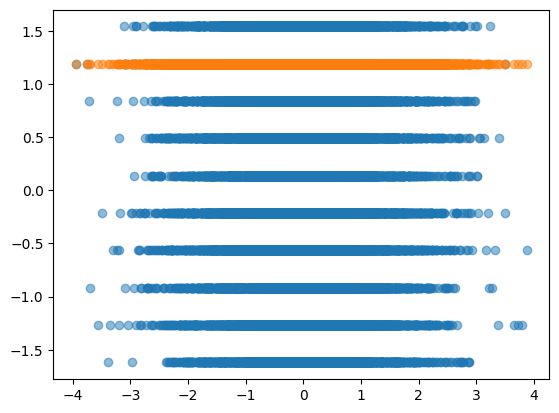

In [165]:
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.5)
plt.scatter(X2[:, 0], X2[:, 1], alpha=0.5)

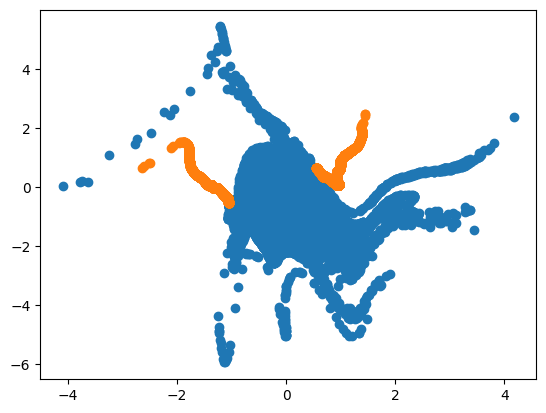

In [143]:
Z1 = np.load('/Users/thepoch/projects/f-dre/poch/data/encodings/custom/maf_biased_z.npy')
Z2 = np.load('/Users/thepoch/projects/f-dre/poch/data/encodings/custom/maf_ref_z.npy')

plt.scatter(Z1[:, 0], Z1[:, 1])
plt.scatter(Z2[:, 0], Z2[:, 1])

In [127]:
len(val_bandit_data['action_context'])

1000

In [188]:
val_bandit_data['action_context']

array([[ 0.44122749, -0.33087015,  2.43077119, ..., -0.59163666,
         0.18760323, -0.32986996],
       [-1.19276461, -0.20487651, -0.35882895, ...,  1.85733101,
        -1.51117956,  0.64484751],
       [-0.98060789, -0.85685315, -0.87187918, ..., -0.36331088,
         0.00328884, -0.10593044],
       ...,
       [-0.28829758, -0.23931692,  1.41225087, ...,  0.25485418,
        -0.87883071, -0.55311421],
       [ 0.80180082, -1.97137816,  0.56385018, ...,  0.00250988,
        -0.26067216, -1.24324752],
       [ 1.37538983,  0.73235714,  0.22472431, ...,  1.62032864,
         0.32752551,  1.36838115]])